In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import gender_guesser.detector as gender

In [20]:
df_authors = pd.read_json("author_list.json")
df_publications = pd.read_json("author_publications.json")

In [21]:
detector = gender.Detector()
def get_gender(name):
    first_name = name.split()[0]
    gender = detector.get_gender(first_name)
    return "male" if gender in ["male", "mostly_male"] else "female" if gender in ["female", "mostly_female"] else "unknown"

df_authors["gender"] = df_authors["display_name"].apply(get_gender)

In [22]:
df_authors = df_authors[df_authors["gender"] != "unknown"]
df_authors = df_authors[["id", "gender"]]

In [23]:
df_publications["is_oa"] = df_publications["open_access"].apply(lambda x: x.get("is_oa", False) if isinstance(x, dict) else False)

In [24]:
author_pubs = []
for _, row in df_publications.iterrows():
    for author in row["authorships"]:
        author_pubs.append({
            "author_id": author["author"]["id"],
            "publication_id": row["id"],
            "is_oa": row["is_oa"]
        })

df_author_pubs = pd.DataFrame(author_pubs)
df_author_pubs = df_author_pubs.merge(df_authors, left_on="author_id", right_on="id")

In [25]:
field_mapping = {
    "Health": ["medicine", "health", "nursing", "biomedical", "pharmacy"],
    "Chemistry": ["chemistry", "chemical"],
    "Physics": ["physics", "quantum", "particle"],
    "Computer Science": ["computer", "informatics", "AI", "artificial intelligence"],
    "Mathematics": ["mathematics", "geometry", "algebra"],
    "Engineering": ["engineering", "mechanical", "civil"],
    "Humanities": ["philosophy", "history", "literature", "sociology", "anthropology"],
    "Social Sciences": ["education", "political", "economics", "law", "management"],
    "Other": []
}


In [26]:
fields_data = []
for _, row in df_publications.iterrows():
    if "topics" in row and isinstance(row["topics"], list):  
        for topic in row["topics"]:
            field_name = topic["display_name"].lower()

            assigned_category = "Other"
            for category, keywords in field_mapping.items():
                if any(word in field_name for word in keywords):
                    assigned_category = category
                    break  

            fields_data.append({
                "publication_id": row["id"],
                "field": assigned_category  
            })

df_fields = pd.DataFrame(fields_data)
df_final = df_author_pubs.merge(df_fields, on="publication_id")

In [27]:
result = df_final.groupby(["gender", "field"])["is_oa"].mean().reset_index()
df_pivot = result.pivot(index="field", columns="gender", values="is_oa").reset_index()
df_pivot = df_pivot.fillna(0)

df_pivot = df_pivot.sort_values("field")

In [28]:
stem_fields = ["Health", "Chemistry", "Physics", "Computer Science", "Mathematics", "Engineering"]
hss_fields = ["Humanities", "Social Sciences"]
df_final["category"] = df_final["field"].apply(lambda x: "STEM" if x in stem_fields else "HSS" if x in hss_fields else "Other")

In [29]:
gender_counts = df_final.groupby(["category", "gender"]).size().unstack()

In [30]:
num_female_authors = gender_counts["female"].sum()
num_male_authors = gender_counts["male"].sum()
print(f"Number of female authors: {num_female_authors}")
print(f"Number of male authors: {num_male_authors}")

Number of female authors: 634
Number of male authors: 1467


<Figure size 1000x600 with 0 Axes>

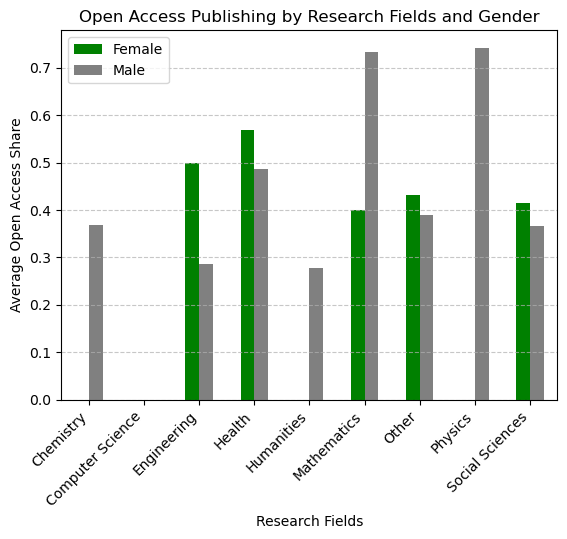

In [31]:
plt.figure(figsize=(10, 6))
df_pivot.set_index("field")[["female", "male"]].plot(kind="bar", stacked=False, color=["green", "grey"])
plt.ylabel("Average Open Access Share")
plt.xlabel("Research Fields")
plt.title("Open Access Publishing by Research Fields and Gender")
plt.xticks(rotation=45, ha="right")
plt.legend(["Female", "Male"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [32]:
print("\nBreakdown by research category:")
print(gender_counts)


Breakdown by research category:
gender    female  male
category              
HSS          117   130
Other        466  1135
STEM          51   202


In [33]:
oa_avg = df_final.groupby(["category", "gender"])["is_oa"].mean().unstack().fillna(0)

for cat in ["STEM", "HSS", "Other"]:
    if cat not in oa_avg.index:
        print(f"Warning: Category '{cat}' is missing in the data. Adding with zero values.")
        oa_avg.loc[cat] = {"female": 0, "male": 0}

In [34]:
oa_avg = oa_avg.sort_index()

In [35]:
print("\nFinal oa_avg DataFrame:")
print(oa_avg)


Final oa_avg DataFrame:
gender      female      male
category                    
HSS       0.376068  0.353846
Other     0.431330  0.389427
STEM      0.529412  0.504950


<Figure size 800x500 with 0 Axes>

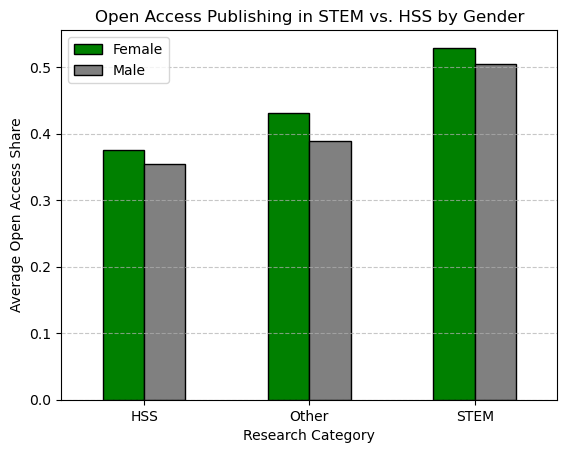

In [37]:
plt.figure(figsize=(8, 5))

oa_avg = oa_avg[["female", "male"]] 

oa_avg.plot(kind="bar", color=["green", "grey"], edgecolor="black")

plt.ylabel("Average Open Access Share")
plt.xlabel("Research Category")
plt.title("Open Access Publishing in STEM vs. HSS by Gender")
plt.xticks(rotation=0)

plt.legend(["Female", "Male"])  

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

